# UCI Heart Disease: Data Exploration (All Populations)

<a id="toc"></a>
## Table of Contents
1. [Introduction](#introduction)
2. [Setup & Data Loading](#setup-data-loading)
3. [Data Dictionary](#data-dictionary)
4. [Target Variable Analysis](#target-variable-analysis)
5. [Univariate Overview](#univariate-overview)
6. [Missing Data Analysis](#missing-data-analysis)
7. [Preliminary Patterns](#preliminary-patterns)
8. [Conclusions & Next Steps](#conclusions-next-steps)


<a id="introduction"></a>
## Introduction

### Context and background
The UCI Heart Disease database contains patient-level clinical measurements collected from four sites:
- Cleveland (USA)
- Hungarian (Hungary)
- Switzerland (Switzerland)
- VA Long Beach (USA)

Although the original database contains many attributes, this project uses a standard 14-variable subset commonly used in published analyses.

### Objectives
- Understand the structure of the combined dataset (all populations pooled).
- Build a clear data dictionary for the 14 key variables.
- Inspect the target distribution and consider modeling formulations.
- Identify missingness patterns and immediate data quality issues.

### Research questions
1. What variables are available in the dataset and what do they represent?
2. What is the distribution of heart disease severity across all samples?
3. What is the extent and pattern of missing data?
4. Are there any immediate data quality issues that need to be addressed?
5. Do missing data patterns suggest the need for population-specific analysis?


<a id="setup-data-loading"></a>
## Setup & Data Loading

We load the combined dataset from `load_datasets.py`. This combined dataframe already includes a `Dataset` identifier column.


In [42]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Statistical and clustering utilities (used later)
from scipy.stats import chi2_contingency
from scipy.cluster.hierarchy import linkage, dendrogram

# Project utilities
from utils.data_quality import (
    calculate_missingness_summary,
    get_complete_case_percentage,
    create_data_quality_report,
)

# Plot style
sns.set_theme(style='whitegrid')

# Display dataframe numerical values up to 2 decimals
pd.options.display.float_format = "{:,.2f}".format

warnings.filterwarnings('ignore')


In [43]:
# Load dataset from all populations
from load_datasets import df_combined

# Work on a copy so we don't accidentally mutate the shared object imported from load_datasets.py
df = df_combined.copy()

# Basic sanity checks
print('Columns:', df.columns.tolist())
df.head()


Columns: ['Age', 'Sex', 'Chest Pain', 'Rest BP', 'Chol', 'FBS', 'Rest ECG', 'Max HR', 'Ex Angina', 'Oldpeak', 'Slope', 'Ca', 'Thal', 'CVD Class', 'Dataset']


,Age,Sex,Chest Pain,Rest BP,Chol,FBS,Rest ECG,Max HR,Ex Angina,Oldpeak,Slope,Ca,Thal,CVD Class,Dataset
0,67.00,1.00,4.00,160.00,286.00,0.00,2.00,108.00,1.00,1.50,2.00,3.0,3.0,2,Cleveland
1,67.00,1.00,4.00,120.00,229.00,0.00,2.00,129.00,1.00,2.60,2.00,2.0,7.0,1,Cleveland
2,37.00,1.00,3.00,130.00,250.00,0.00,0.00,187.00,0.00,3.50,3.00,0.0,3.0,0,Cleveland
3,41.00,0.00,2.00,130.00,204.00,0.00,2.00,172.00,0.00,1.40,1.00,0.0,3.0,0,Cleveland
4,56.00,1.00,2.00,120.00,236.00,0.00,0.00,178.00,0.00,0.80,1.00,0.0,3.0,0,Cleveland


Here we see the following columns: 
- Age
- Sex
- Chest Pain
- Rest BP
- Chol
- FBS
- Rest ECG
- Max HR
- Ex Angina
- Oldpeak
- Slope
- Ca
- Thal
- CVD Class
- Dataset

Please note that these are not the exact same column names that were used in the original dataset. I modified these so that they are easier to understand (see `load_datasets.py`). The `Dataset` column indicator is also not part of the original dataset and is there to mark which population the data observation comes from.

### Initial data inspection
We start with dataset shape, dtypes, and a quick view of how many samples come from each population.


In [66]:
# Initial inspection: shape, head, info
print('=== Dataset Dimensions ===')
print(f'Rows: {df.shape[0]:,}, Columns: {df.shape[1]}\n')

print('=== Samples By Population ===')
print(df['Dataset'].value_counts())
print()

print('=== Data Types ===')
print(df.dtypes)
print()

print('=== Dataset Info ===')
df.info()

=== Dataset Dimensions ===
Rows: 916, Columns: 16

=== Samples By Population ===
Dataset
Cleveland        302
Hungarian        293
VA Long Beach    199
Switzerland      122
Name: count, dtype: int64

=== Data Types ===
Age           float64
Sex           float64
Chest Pain    float64
Rest BP       float64
Chol          float64
FBS           float64
Rest ECG      float64
Max HR        float64
Ex Angina     float64
Oldpeak       float64
Slope         float64
Ca            float64
Thal          float64
CVD Class       int64
Dataset        object
Any CVD       float64
dtype: object

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         916 non-null    float64
 1   Sex         916 non-null    float64
 2   Chest Pain  916 non-null    float64
 3   Rest BP     857 non-null    float64
 4   Chol        886 non-null    float64
 

<a id="data-dictionary"></a>
## Data Dictionary

Below is a data dictionary for the 14 key variables used in this project.

Assumption:
- Encodings follow the standard UCI Heart Disease documentation. We will verify by checking observed value domains/ranges.


| Variable | Type | Units | Clinical Meaning | Expected Range / Codes |
|---|---:|---|---|---|
| Age | Numeric | years | Age of the patient | 0-120 (plausible) |
| Sex | Categorical | N/A | Biological sex | 1 = male, 0 = female |
| Chest Pain | Categorical | N/A | Chest pain type | 1 typical angina, 2 atypical angina, 3 non-anginal, 4 asymptomatic |
| Rest BP | Numeric | mmHg | Resting blood pressure (on admission) | ~80-250 (plausible) |
| Chol | Numeric | mg/dl | Serum cholesterol | ~50-700 (plausible) |
| FBS | Binary | N/A | Fasting blood sugar > 120 mg/dl | 1 = true, 0 = false |
| Rest ECG | Categorical | N/A | Resting ECG result | 0 normal, 1 ST-T abnormality, 2 LV hypertrophy |
| Max HR | Numeric | bpm | Maximum heart rate achieved | ~60-220 (plausible) |
| Ex Angina | Binary | N/A | Exercise-induced angina | 1 = yes, 0 = no |
| Oldpeak | Numeric | N/A | ST depression induced by exercise relative to rest | ~0-10 (plausible) |
| Slope | Categorical | N/A | Slope of peak exercise ST segment | 1 upsloping, 2 flat, 3 downsloping |
| Ca | Categorical / Numeric | count | # major vessels colored by fluoroscopy | 0-3 |
| Thal | Categorical | N/A | Thalassemia/defect status | 3 normal, 6 fixed defect, 7 reversible defect |
| CVD Class | Ordinal Target | N/A | Disease presence/severity | 0 no disease, 1-4 increasing severity |


<a id="target-variable-analysis"></a>
## Target Variable Analysis

We analyze `CVD Class` (0-4):
- 0 indicates no disease
- 1-4 indicate increasing severity

We visualize both:
- **Multiclass/ordinal** distribution (0-4)
- A **binary** variant (`Any CVD`) that collapses 1-4 into a single positive class


In [45]:
# Ensure CVD Class is numeric (datasets sometimes load numeric columns as object)
df['CVD Class'] = pd.to_numeric(df['CVD Class'], errors='coerce')

cvd_counts = df['CVD Class'].value_counts(dropna=False).sort_index()
cvd_percent = (cvd_counts / cvd_counts.sum() * 100).round(2)

cvd_distribution = pd.DataFrame({'Count': cvd_counts, 'Percent': cvd_percent})
cvd_distribution


,Count,Percent
CVD Class,,
0,409,44.65
1,264,28.82
2,108,11.79
3,107,11.68
4,28,3.06


The table above makes it clear that the CVD classes are not balanced, with the majority of cases (44.65%) falling in the no CVD classification (0). On the flip side, we see that only 28 cases (3.06%) fall into the very severe CVD category. From a health point of view this is a positive, but when it comes to classification accuracy, this class may not have enough samples to make accurate predictions. This will be an issue to keep in mind and to address as the analysis progresses.

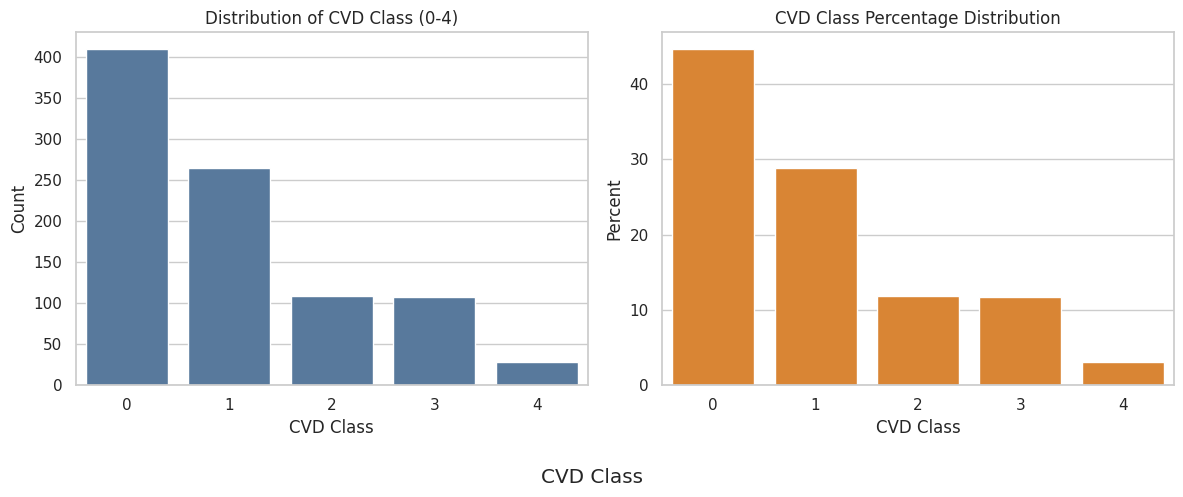

In [69]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
# Visualize class frequencies (0-4)

order = sorted(df['CVD Class'].dropna().unique())
sns.countplot(data=df, x='CVD Class', order=order, color='#4C78A8', ax=ax[0])
ax[0].set_title('Distribution of CVD Class (0-4)')
ax[0].set_ylabel('Count')

sns.barplot(x=cvd_distribution.index, y=cvd_distribution['Percent'], color='#F58518')
ax[1].set_title('CVD Class Percentage Distribution')
ax[1].set_ylabel('Percent')

fig.supxlabel('CVD Class')
plt.tight_layout()
plt.show()


The plots above provide a visual representation of the data found in the table. I find it interesting that classification of level 2 and 3 CVD have essentially the same frequency. As an alternative to having multiple classifications, we explore the distribution in a binary format; CVD is present or is not present.

In [ ]:
# Consider binary vs multi-class approaches
df['Any CVD'] = (df['CVD Class'] > 0).astype('float')

binary_counts = df['Any CVD'].value_counts(dropna=False).sort_index()
binary_percent = (binary_counts / binary_counts.sum() * 100).round(2)

pd.DataFrame({'Count': binary_counts, 'Percent': binary_percent}).rename(index={0.0: 'No CVD', 1.0: 'Any CVD'})


,Count,Percent
Any CVD,,
No CVD,409,44.65
Any CVD,507,55.35


### Binary Target Interpretation

Looking at this as a binary classification, we see that there is a greater balance between the CVD classes. While this kind of classification reduces the complexity of the problem, is also reduces the granularity, and as a result, the potential importance of a classification. If someone is told they have cardiovascular disease, they (and the physician) would likely also want to know the severity/progression of the disease to take the most appropriate course of action.

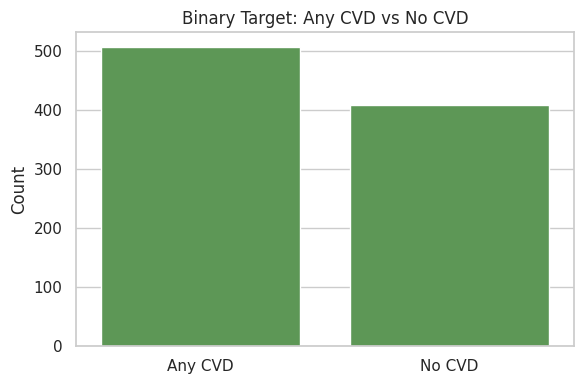

In [71]:
# Plot binary target distribution
plt.figure(figsize=(6, 4))
plot_df = df.copy()
plot_df['Any CVD Label'] = plot_df['Any CVD'].map({0.0: 'No CVD', 1.0: 'Any CVD'})
sns.countplot(data=plot_df, x='Any CVD Label', color='#54A24B')
plt.title('Binary Target: Any CVD vs No CVD')
plt.xlabel('')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


Modeling note:
- If we care about **severity**, we should treat `CVD Class` as ordinal/multiclass.
- If we primarily care about **presence vs absence**, the binary target is simpler and often more stable with limited sample sizes.


<a id="univariate-overview"></a>
## Univariate Overview

Here we take a variable-by-variable look at:
- Summary statistics
- Data type verification
- Value domain/range checks (flags for review)

Important:
- We are *flagging* potential issues, not automatically correcting/removing values.


In [73]:
# Coerce known numeric columns to numeric for consistent summary statistics
numeric_like_cols = [
    'Age', 'Sex', 'Chest Pain', 'Rest BP', 'Chol', 'FBS', 'Rest ECG',
    'Max HR', 'Ex Angina', 'Oldpeak', 'Slope', 'Ca', 'Thal', 'CVD Class'
]

for col in numeric_like_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Summary stats (include='all' to include Dataset as well)
df.describe(include='all').round(2).T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,916.00,NaN,NaN,NaN,53.54,9.37,29.00,47.00,54.00,60.00,77.00
Sex,916.00,NaN,NaN,NaN,0.79,0.41,0.00,1.00,1.00,1.00,1.00
Chest Pain,916.00,NaN,NaN,NaN,3.26,0.93,1.00,3.00,4.00,4.00,4.00
Rest BP,857.00,NaN,NaN,NaN,132.15,19.06,0.00,120.00,130.00,140.00,200.00
Chol,886.00,NaN,NaN,NaN,199.32,110.78,0.00,175.25,223.00,268.00,603.00
FBS,827.00,NaN,NaN,NaN,0.17,0.37,0.00,0.00,0.00,0.00,1.00
Rest ECG,914.00,NaN,NaN,NaN,0.60,0.80,0.00,0.00,0.00,1.00,2.00
Max HR,861.00,NaN,NaN,NaN,137.52,25.92,60.00,120.00,140.00,157.00,202.00
Ex Angina,861.00,NaN,NaN,NaN,0.39,0.49,0.00,0.00,0.00,1.00,1.00
Oldpeak,854.00,NaN,NaN,NaN,0.88,1.09,-2.60,0.00,0.50,1.50,6.20


In [74]:
# Verify data types after coercion
print(df.dtypes)

# Quick check: how many non-numeric values did coercion turn into NaN?
coercion_issues = {}
orig = df_combined.copy()
for col in numeric_like_cols:
    orig_col = orig[col]
    coerced = pd.to_numeric(orig_col, errors='coerce')
    coercion_issues[col] = int((orig_col.notnull() & coerced.isnull()).sum())

pd.Series(coercion_issues).sort_values(ascending=False)


Age           float64
Sex           float64
Chest Pain    float64
Rest BP       float64
Chol          float64
FBS           float64
Rest ECG      float64
Max HR        float64
Ex Angina     float64
Oldpeak       float64
Slope         float64
Ca            float64
Thal          float64
CVD Class       int64
Dataset        object
Any CVD       float64
dtype: object


Age           0
Sex           0
Chest Pain    0
Rest BP       0
Chol          0
FBS           0
Rest ECG      0
Max HR        0
Ex Angina     0
Oldpeak       0
Slope         0
Ca            0
Thal          0
CVD Class     0
dtype: int64

In [51]:
# Value range / domain checks
categorical_domains = {
    'Sex': {0, 1},
    'Chest Pain': {1, 2, 3, 4},
    'FBS': {0, 1},
    'Rest ECG': {0, 1, 2},
    'Ex Angina': {0, 1},
    'Slope': {1, 2, 3},
    'Ca': {0, 1, 2, 3},
    'Thal': {3, 6, 7},
    'CVD Class': {0, 1, 2, 3, 4},
}

# Plausible ranges (screening thresholds; adjust if clinical context suggests otherwise)
range_checks = {
    'Age': (0, 120),
    'Rest BP': (80, 250),
    'Chol': (50, 700),
    'Max HR': (60, 220),
    'Oldpeak': (0, 10),
}

invalid_domain_counts = {}
for col, allowed in categorical_domains.items():
    invalid_domain_counts[col] = int((~df[col].isin(allowed) & df[col].notnull()).sum())

out_of_range_counts = {}
for col, (min_val, max_val) in range_checks.items():
    out_of_range_counts[col] = int((((df[col] < min_val) | (df[col] > max_val)) & df[col].notnull()).sum())

quality_flags = pd.DataFrame({
    'Invalid_Domain_Count': pd.Series(invalid_domain_counts),
    'Out_Of_Range_Count': pd.Series(out_of_range_counts),
}).fillna(0).astype(int)

quality_flags


,Invalid_Domain_Count,Out_Of_Range_Count
Age,0,0
CVD Class,0,0
Ca,0,0
Chest Pain,0,0
Chol,0,171
Ex Angina,0,0
FBS,0,0
Max HR,0,0
Oldpeak,0,12
Rest BP,0,1


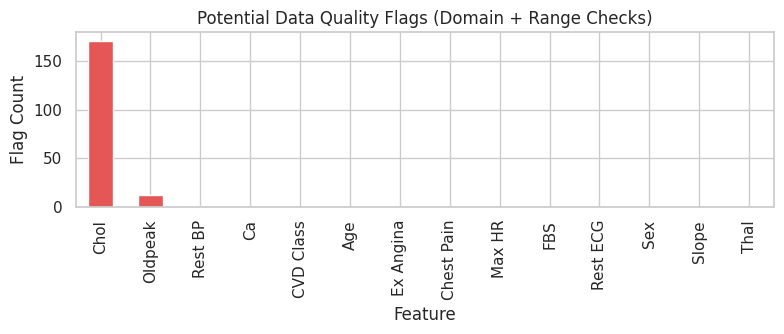

In [52]:
# Visualize total flag counts by feature
plt.figure(figsize=(8, 3.5))
quality_flags.sum(axis=1).sort_values(ascending=False).plot(kind='bar', color='#E45756')
plt.title('Potential Data Quality Flags (Domain + Range Checks)')
plt.xlabel('Feature')
plt.ylabel('Flag Count')
plt.tight_layout()
plt.show()


<a id="missing-data-analysis"></a>
## Missing Data Analysis

We quantify missingness and explore patterns:
- How much is missing per variable?
- Do missingness patterns co-occur between variables?
- Is missingness plausibly MCAR (random), MAR (depends on observed data), or MNAR (depends on unobserved data)?

Important:
- MNAR cannot be confirmed from observed data alone.
- What we *can* do is look for evidence against MCAR (e.g., missingness depends on dataset or target).


In [ ]:
# Quantify missing values per variable
missing_summary = calculate_missingness_summary(df)
missing_summary.round(2)

,Feature,Missing_Count,Missing_Percent
0,Ca,608,66.38
1,Thal,483,52.73
2,Slope,308,33.62
3,FBS,89,9.72
4,Oldpeak,62,6.77
5,Rest BP,59,6.44
6,Ex Angina,55,6.00
7,Max HR,55,6.00
8,Chol,30,3.28
9,Rest ECG,2,0.22


Note the three variables that are missing a large percentage of values (>= 30%) across the combined dataset. These are Ca, Thal, and Slope, which all require specialized equipment to be completed and may not be checked for if CVD is not suspected. This isn't conclusive, but we can begin to theorize what might be driving such large numbers of missing values.

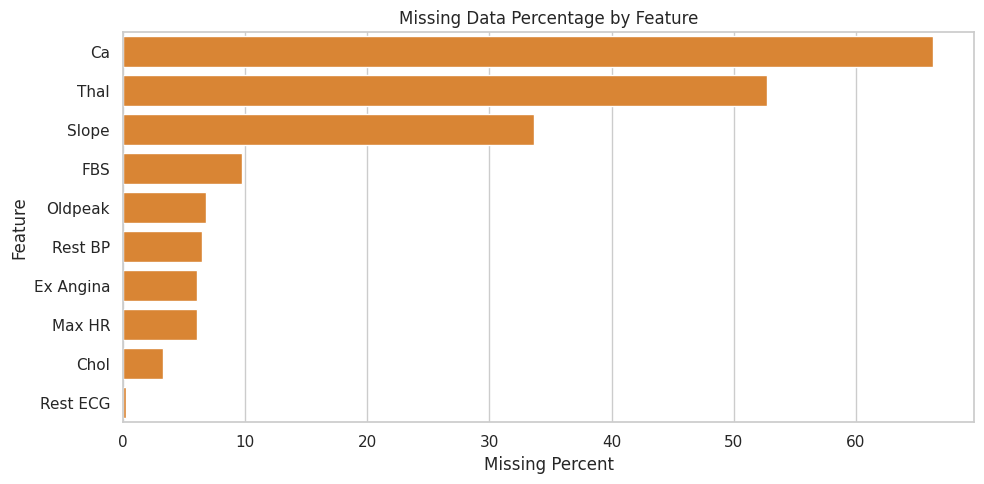

In [54]:
# Visualize missingness percentage per feature
plt.figure(figsize=(10, 5))
sns.barplot(data=missing_summary, y='Feature', x='Missing_Percent', color='#F58518')
plt.title('Missing Data Percentage by Feature')
plt.xlabel('Missing Percent')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [76]:
# Row-level completeness
complete_cases_percent = get_complete_case_percentage(df)
incomplete_percent = 100 - complete_cases_percent

print(f'Complete cases (no missing values): {complete_cases_percent:.2f}%')
print(f'Incomplete cases (>=1 missing value): {incomplete_percent:.2f}%')

Complete cases (no missing values): 32.53%
Incomplete cases (>=1 missing value): 67.47%


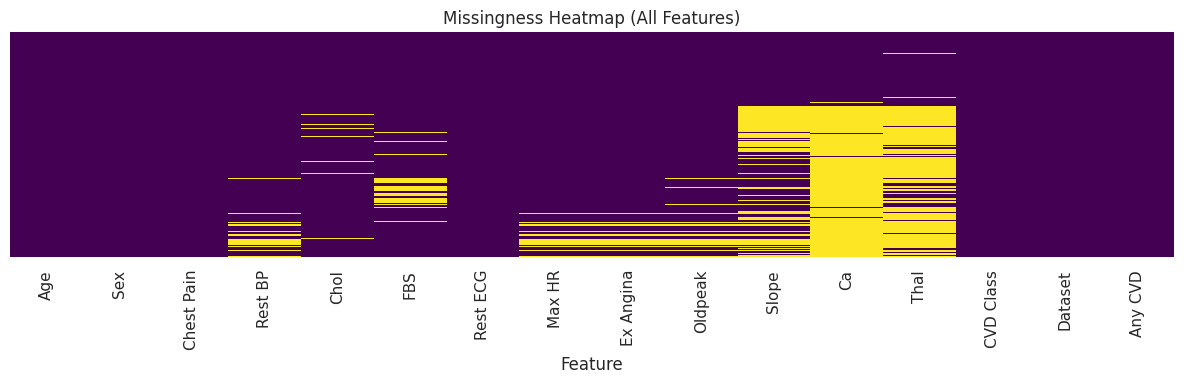

In [77]:
# Visualize missing data patterns (heatmap)
plt.figure(figsize=(12, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missingness Heatmap (All Features)')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

### Missingness by population
Because this dataset is pooled across multiple sites, a key question is whether missingness is uniform across populations (it usually is not).


In [55]:
# Missingness percentage by population and feature
missing_by_dataset = df.groupby('Dataset').apply(lambda x: x.isnull().mean() * 100)

# Keep only features with any missingness
missing_by_dataset = missing_by_dataset.loc[:, missing_by_dataset.max() > 0].round(2)
missing_by_dataset


,Rest BP,Chol,FBS,Rest ECG,Max HR,Ex Angina,Oldpeak,Slope,Ca,Thal
Dataset,,,,,,,,,,
Cleveland,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.32,0.66
Hungarian,0.34,7.85,2.73,0.34,0.34,0.34,0.00,64.51,98.98,90.44
Switzerland,1.64,0.00,60.66,0.82,0.82,0.82,4.92,13.93,95.90,41.80
VA Long Beach,28.14,3.52,3.52,0.00,26.63,26.63,28.14,51.26,98.99,82.91


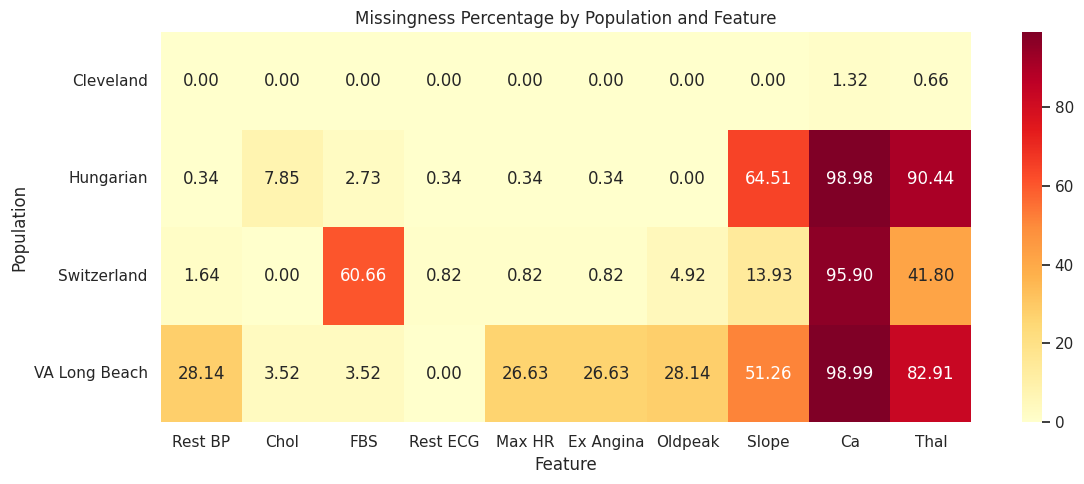

In [56]:
# Heatmap: missingness percentage by dataset and feature
plt.figure(figsize=(12, 5))
sns.heatmap(missing_by_dataset, annot=True, fmt='.2f', cmap='YlOrRd')
plt.title('Missingness Percentage by Population and Feature')
plt.xlabel('Feature')
plt.ylabel('Population')
plt.tight_layout()
plt.show()


### Feature missingness by Dataset
As suspected, the missing values are far from uniformly distributed. This is important to note as it suggests that there are differences in the qualities of the hospitals/regions that could impact future decisions. From the heatmap above, we can already make the following conclusions:

#### 1) Missingness is highly structured and site specific

Missing data rates differ dramatically by hospital, not just by variable. Cleveland is nearly complete, while Hungarian, Switzerland, and VA Long Beach have systematic gaps that reach 90 to 99 percent for some features.

This immediately rules out missing completely at random. The missingness depends on the data collection site and therefore on institutional practices, available equipment, and clinical protocols.

#### 2) Certain variables are effectively unavailable in some hospitals

Variables like Ca and Thal are almost entirely missing in multiple datasets. That means that for those hospitals, these features are essentially structurally absent. This implies that any model or inference relying on these variables is implicitly restricted to Cleveland or a very small subset of patients.

#### 3) Evidence of multiple missingness mechanisms

What we see here is likely a mixture of different variables at play

- Structural missingness due to different hospital protocols
- Missing at random (MAR) conditional on hospital
- Possibly missing not at random (MNAR) if test ordering depended on patient severity or suspected diagnosis

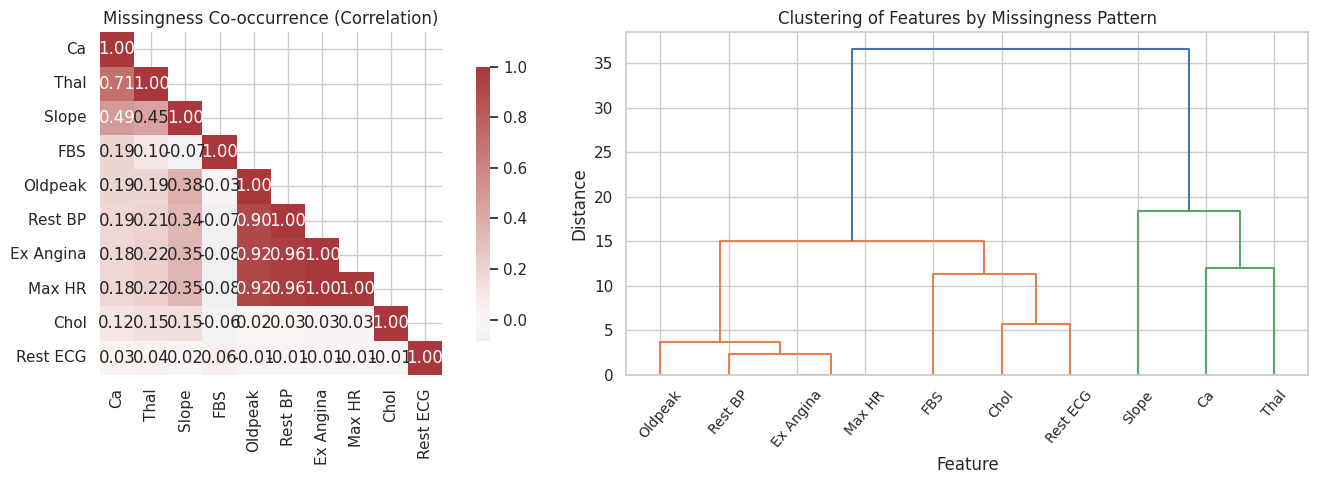

In [88]:
# Check if missingness is correlated between variables
missing_cols = missing_summary['Feature'].tolist()

missing_matrix = df[missing_cols].isnull().astype(int)
cooccurrence = missing_matrix.corr()

# Heatmap + hierarchical clustering side-by-side
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))
mask = np.triu(np.ones_like(cooccurrence, dtype=bool), k=1)

sns.heatmap(
    cooccurrence,
    annot=True,
    fmt='.2f',
    cmap='vlag',
    center=0,
    square=True,
    mask=mask,
    cbar_kws={'shrink': 0.8},
    ax=ax[0],
)
ax[0].set_title('Missingness Co-occurrence (Correlation)')

linkage_matrix = linkage(missing_matrix.T, method='ward')
dendrogram(
    linkage_matrix,
    labels=missing_cols,
    leaf_rotation=50,
    leaf_font_size=10,
    ax=ax[1],
)
ax[1].set_title('Clustering of Features by Missingness Pattern')
ax[1].set_xlabel('Feature')
ax[1].set_ylabel('Distance')

plt.tight_layout()
plt.show()


In [89]:
# Evidence against MCAR: does missingness depend on population (Dataset)?

def cramers_v_from_crosstab(crosstab: pd.DataFrame) -> float:
    chi2, _, _, _ = chi2_contingency(crosstab)
    n = crosstab.to_numpy().sum()
    r, k = crosstab.shape
    denom = n * max(min(r - 1, k - 1), 1)
    return float(np.sqrt(chi2 / denom))

missingness_by_dataset_tests = []
for feature in missing_cols:
    is_missing = df[feature].isnull()
    ct = pd.crosstab(df['Dataset'], is_missing)
    print(ct)
    chi2, p_value, dof, expected = chi2_contingency(ct)
    v = cramers_v_from_crosstab(ct)

    missingness_by_dataset_tests.append({
        'Feature': feature,
        'p_value': p_value,
        'Cramers_V': v,
        'Missing_%_Overall': float(df[feature].isnull().mean() * 100),
    })

missingness_by_dataset_tests = pd.DataFrame(missingness_by_dataset_tests).sort_values('p_value')
missingness_by_dataset_tests.head(10)


Ca             False  True 
Dataset                    
Cleveland        298      4
Hungarian          3    290
Switzerland        5    117
VA Long Beach      2    197
Thal           False  True 
Dataset                    
Cleveland        300      2
Hungarian         28    265
Switzerland       71     51
VA Long Beach     34    165
Slope          False  True 
Dataset                    
Cleveland        302      0
Hungarian        104    189
Switzerland      105     17
VA Long Beach     97    102
FBS            False  True 
Dataset                    
Cleveland        302      0
Hungarian        285      8
Switzerland       48     74
VA Long Beach    192      7
Oldpeak        False  True 
Dataset                    
Cleveland        302      0
Hungarian        293      0
Switzerland      116      6
VA Long Beach    143     56
Rest BP        False  True 
Dataset                    
Cleveland        302      0
Hungarian        292      1
Switzerland      120      2
VA Long Beach    143

,Feature,p_value,Cramers_V,Missing_%_Overall
0,Ca,0.00,0.97,66.38
1,Thal,0.00,0.79,52.73
3,FBS,0.00,0.68,9.72
2,Slope,0.00,0.60,33.62
5,Rest BP,0.00,0.47,6.44
6,Ex Angina,0.00,0.46,6.00
7,Max HR,0.00,0.46,6.00
4,Oldpeak,0.00,0.45,6.77
8,Chol,0.00,0.19,3.28
9,Rest ECG,0.34,0.06,0.22


In [ ]:
# Evidence against MCAR: does missingness depend on the target label (CVD Class)?

missingness_vs_target = []
for feature in missing_cols:
    is_missing = df[feature].isnull()

    # CVD Class is ordinal (0-4); we use a chi-square test on the contingency table.
    ct = pd.crosstab(df['CVD Class'], is_missing)

    # Drop rows where CVD Class itself is missing (if any)
    ct = ct.dropna(axis=0, how='any')

    # If a feature is missing in all or none rows, chi-square isn't meaningful.
    if ct.shape[1] < 2:
        continue

    chi2, p_value, dof, expected = chi2_contingency(ct)
    v = cramers_v_from_crosstab(ct)

    missingness_vs_target.append({
        'Feature': feature,
        'p_value': p_value,
        'Cramers_V': v,
    })

missingness_vs_target = pd.DataFrame(missingness_vs_target).sort_values('p_value')
missingness_vs_target.head(10)


,Feature,p_value,Cramers_V
2,Slope,0.00,0.26
3,FBS,0.00,0.21
0,Ca,0.00,0.17
1,Thal,0.00,0.14
5,Rest BP,0.01,0.12
4,Oldpeak,0.01,0.12
6,Ex Angina,0.07,0.10
7,Max HR,0.07,0.10
8,Chol,0.26,0.08
9,Rest ECG,0.29,0.07


### Missing Data Observations

Missing data exhibited strong hospital level structure, with substantial variation in both the rate and pattern of missingness across sites. Several clinically relevant variables such as Ca and Thal were nearly absent in multiple hospitals, indicating structural rather than random missingness. While higher missingness was more common for tests requiring specialized equipment, the incomplete alignment of missingness across features suggests that hospital specific clinical practices played a significant role. These patterns imply that standard missing at random assumptions are unlikely to hold, and that analyses incorporating these variables are effectively limited to subsets of the data.


<a id="preliminary-patterns"></a>
## Preliminary Patterns

We summarize immediate data quality issues and flag areas for follow-up:
- Duplicates and global completeness
- Variables with especially high missingness
- Potential outliers / implausible values (screening)


In [62]:
# Data quality report (duplicates, completeness, missing cells)
quality_report = create_data_quality_report(df, dataset_name='Combined')
pd.Series(quality_report)


Dataset Name                   Combined
N Observations                      916
N Features                           16
N Duplicates                          2
Percent Duplicates                 0.22
N Complete Cases                    298
Percent Complete Cases            32.53
Total Missing Cells                1751
Percent Missing Cells             11.95
Features With Missing Cells          10
dtype: object

In [ ]:
# Variables with high missing rates (>= 30%)
concerning_missing = missing_summary[missing_summary['Missing_Percent'] >= 30].copy()
concerning_missing


,Feature,Missing_Count,Missing_Percent
0,Ca,608,66.38
1,Thal,483,52.73
2,Slope,308,33.62


In [85]:
# Using IQR-based flags for important numeric variables
numeric_vars = ['Age', 'Rest BP', 'Chol', 'Max HR', 'Oldpeak']

def calculate_iqr_bounds (x: pd.Series, threshold=1.5):
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - threshold * iqr
    upper = q3 + threshold * iqr
    return lower, upper

def is_iqr_outlier (val: float, lower: float, upper:float) -> bool:
    return val < lower or val > upper 

outlier_counts = {}
for col in numeric_vars:
    x = df[col].dropna()
    if len(x) == 0:
        outlier_counts[col] = 0
        continue

    low, up = calculate_iqr_bounds(x)
    outlier_counts[col] = int(df[col].map(lambda val: is_iqr_outlier(val, low, up)).sum())

outlier_counts = pd.Series(outlier_counts).sort_values(ascending=False)
outlier_counts.name = 'IQR Outlier Count'

outlier_counts

Chol       182
Rest BP     28
Oldpeak     16
Max HR       2
Age          0
Name: IQR Outlier Count, dtype: int64

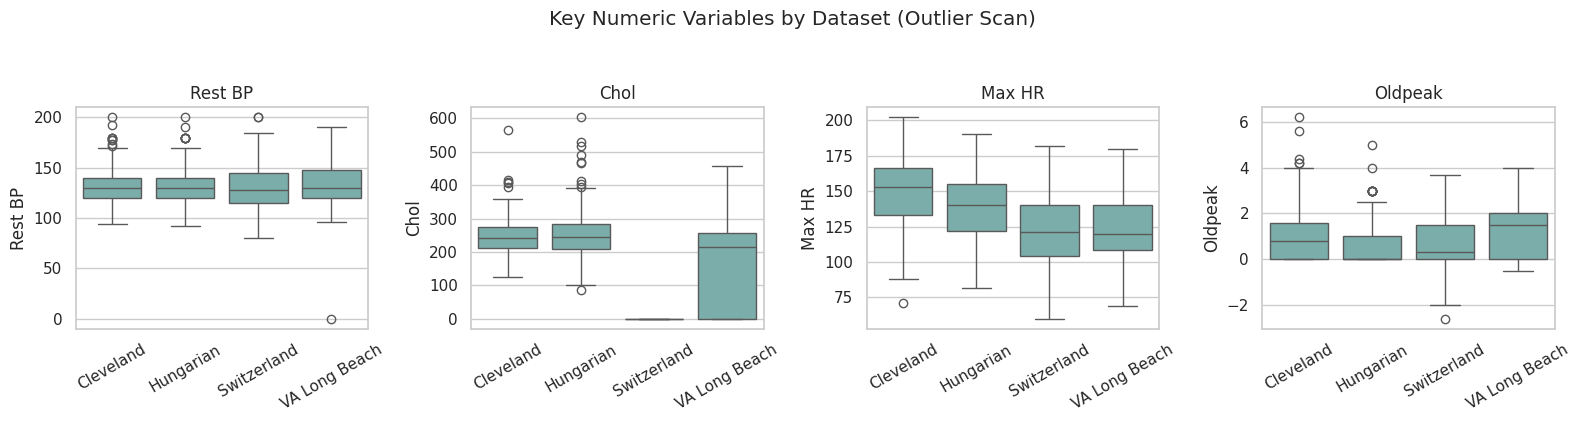

In [65]:
# Boxplots for quick outlier review (by dataset)
plot_vars = ['Rest BP', 'Chol', 'Max HR', 'Oldpeak']

fig, axes = plt.subplots(nrows=1, ncols=len(plot_vars), figsize=(4 * len(plot_vars), 4))
for ax, col in zip(axes, plot_vars):
    sns.boxplot(data=df, x='Dataset', y=col, ax=ax, color='#72B7B2')
    ax.set_title(col)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=30)

plt.suptitle('Key Numeric Variables by Dataset (Outlier Scan)', y=1.05)
plt.tight_layout()
plt.show()


<a id="conclusions-next-steps"></a>
## Conclusions & Next Steps

### Summary of key findings
- The combined dataset includes four populations with different sample sizes.
- The target (`CVD Class`) distribution can be treated as ordinal/multiclass (0-4) or collapsed to a binary outcome (Any CVD).
- Missingness is substantial in several variables and missingness patterns are correlated across features.
- Missingness appears to vary by population (Dataset), which is evidence against MCAR and suggests site-dependent data collection.

### Hypothesis: Are populations different?
Given the missingness differences by dataset (and likely distributional differences in key predictors), the four populations may not be directly comparable without adjustments.

### Transition
Next, we move to population-specific analysis to:
- Compare baseline characteristics by dataset
- Quantify missingness and measurement differences by dataset
- Decide whether populations can be pooled, and what missing-data strategy is appropriate per population

This is the motivation for `2_population_analysis_and_cleaning.ipynb`.
